In [27]:
# import the master.xlsx file and store it in pandas dataframe
import pandas as pd
import numpy as np
from pandasql import sqldf
import os
import glob

# load the excel file
df = pd.read_excel('master.xlsx')

df = df.astype(str)
# drop the column HDI for year
df = df.drop('HDI for year', axis=1)

numDims = df.shape[1]
minSupport = 20
cardinality = []

# get the cardinality of each dimension
for i in range(numDims):
    cardinality.append(len(df.iloc[:,i].unique()))

# arrange the dataframes colums in the descending order of cardinality
df = df.iloc[:,np.argsort(cardinality)[::-1]]

cardinality = []
for i in range(numDims):
    cardinality.append(len(df.iloc[:,i].unique()))


df.head()

,population,suicides/100k pop,gdp_for_year ($),country-year,gdp_per_capita ($),suicides_no,country,year,generation,age,sex
0,312900,6.71,2156624900,Albania1987,796,21,Albania,1987,Generation X,15-24 years,male
1,308000,5.19,2156624900,Albania1987,796,16,Albania,1987,Silent,35-54 years,male
2,289700,4.83,2156624900,Albania1987,796,14,Albania,1987,Generation X,15-24 years,female
3,21800,4.59,2156624900,Albania1987,796,1,Albania,1987,G.I. Generation,75+ years,male
4,274300,3.28,2156624900,Albania1987,796,9,Albania,1987,Boomers,25-34 years,male


In [28]:
# calculate the memory of the selected dataframe in KB
def create_pages(main_memory_kb, cdf):

    total_size_kb = cdf.memory_usage().sum()/1024



    # calculate the number of pages
    numPages = total_size_kb/main_memory_kb

    # ceil the number of pages
    numPages = np.ceil(numPages)


    # calculate the number of rows per page
    numRowsPerPage = int(cdf.shape[0]/numPages)



    # delete all the files in the directory pages
    files = glob.glob('pages/*')
    for f in files:
        os.remove(f)


    # write each small page to pickle file
    for i in range(int(numPages)):
        cdf.iloc[i*numRowsPerPage:(i+1)*numRowsPerPage,:].to_pickle('pages/page'+str(i)+'.pkl')


    return numPages


In [35]:
def write_file(start, end, val, count, cdf):
    
    file_name = "output/" + str(start) + "-" + str(end) + ".txt"

    with open(file_name,"a") as file:
        file.write(str(val) + " " + str(count) + "\n")



def BUC(cdf, start, end):

    if(end >= numDims):
        return
    countdf = sqldf(f'select \"{cdf.columns[end]}\", COUNT(*) as count from cdf group by \"{cdf.columns[end]}\" order by COUNT(*) DESC',locals())
    # return countdf
    
    # traverse the countdf and use recursive buc
    for i in range(len(countdf)):
        if countdf.iloc[i,1] >= minSupport:

            val = countdf.iloc[i,0]
            tempdf = sqldf(f'select * from cdf where \"{cdf.columns[end]}\" = \"{countdf.iloc[i,0]}\" LIMIT 1',locals())

            # only consider coloums from start to end
            tempdf = tempdf.iloc[:,start:end+1]

            # get the first row of the tempdf
            tempdf = tempdf.iloc[0,:]

            # append all the coloums in tempdf to a string separated by ~
            tempdf = " ~ ".join(tempdf)


            nextdf = sqldf(f'select * from cdf where \"{cdf.columns[end]}\" = \"{countdf.iloc[i,0]}\" ',locals())
            BUC(nextdf, start, end+1)

    return
    

In [ ]:
import time
minSupport = 500
main_memory_kb = 100


# change main_memory from 100 to 4000 in steps of 300
# caculate the time taken for each main_memory
# plot the graph of time vs main_memory

memory_list = []
time_list = []

for k in range(100, 4000, 300):

    main_memory_kb = k
    print("Memory" + str(main_memory_kb))
    
    
    numPages = create_pages(main_memory_kb, df)
    start_time = time.time()

    for i in range(int(numPages)):
        print("    Page: ", i)
    
        cdf = pd.read_pickle('pages/page'+str(i)+'.pkl')
        for j in range(numDims):
            print("        dimension: " + str(j))
            BUC(cdf, j, j)

    
    end_time = time.time()
    time_list.append(end_time - start_time)
    memory_list.append(main_memory_kb)
        

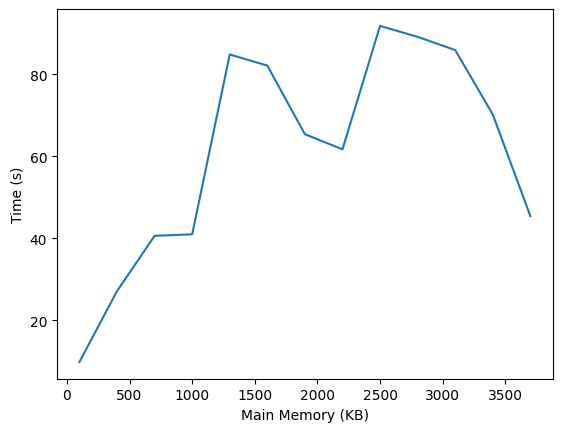

In [38]:
# numPages = create_pages(main_memory_kb, df)




# for i in range(int(numPages)):
#     print("page: " + str(i))
#     cdf = pd.read_pickle('pages/page'+str(i)+'.pkl')
#     for j in range(numDims):
#         print("    dimension: " + str(j))
#         BUC(cdf, j, j)

# plot the graph of time vs main_memory
import matplotlib.pyplot as plt
plt.plot(memory_list, time_list)
plt.xlabel('Main Memory (KB)')
plt.ylabel('Time (s)')
plt.show()